Ce code génére des observations y et l'état du système x_true au cours du temps
à partir des valeurs de R et Q défini.On réalise un filtre de Kalman et un 
lissage de Kalman sur ces données en faisant varier la valeur de R.
On va réaliser cette opération un certain nombre de fois où l'on va generer des
nouvelles données à chaque fois

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Données 
S=100 #Nombre de fois que l'on va generer les données
T=1000 #Nombre d'itérations
Q_true=1 #Matrice de covariance de eta (ici scalaire)
R_true=1 #Matrice de covariance de epsilon (ici scalaire)
N=1000 #Nombre de valeurs de R différentes 


R_var=np.linspace(0.01,4,N) # Différentes valeurs de R 

RMSE=np.zeros((N,S)) # Matrice stockant la RMSE pour chaque valeur de R durant les S simulations
mediane=np.zeros(N) #Vecteur regroupant la médiane de la RMSE pour chaque valeur de R sur toute les simulations
cinqp=np.zeros(N) #Vecteur regroupant le quantile de 5% de la RMSE pour chaque valeur de R sur toute les simulations
quatp=np.zeros(N) #Vecteur regroupe le quantile de 95% de la RMSE pour chaque valeur de R sur toute les simulations

#Calcul du temps d'éxecution du code 
t1=time.time()

for k in range(S):
    np.random.seed(k)
    
    # Generate true state and noisy observation
    x_true=np.zeros(T) # Vecteur de l'état du système à chaque instant t
    y=np.zeros(T) # Vecteur des observations à chaque instant t 
    for t in range(T):
        x_true[t]=0.95*x_true[t-1]+np.random.normal(0,Q_true)
        y[t]=x_true[t]+np.random.normal(0,R_true)
        
    #Boucle sur le nombre d'éléments dans le vecteur R_var
    for r in range(N):
        # Kalman filter
        
        #initial condition
        xb=x_true[0]
        B=1
        
        #Filter Parameters
        M=0.95
        Q=Q_true
        H=1
        R=R_var[r]
        
        #Kalman filter (forward)
        xf=np.zeros(T);Pf=np.zeros(T);xa=np.zeros(T);Pa=np.zeros(T)
        for t in range(T):
            if t==0:
                xf[t]=xb
                Pf[t]=B
            else:
                xf[t]=M*xa[t-1]
                Pf[t]=M**2*Pa[t-1]+Q
            K=Pf[t]*H/(H**2*Pf[t]+R)
            xa[t]=xf[t]+K*(y[t]-H*xf[t])
            Pa[t]=(1-K*H)*Pf[t]
        
        # Kalman Smoother
        xs=np.zeros(T);Ps=np.zeros(T)
        for t in range(T-1,-1,-1):
            if t==T-1:
                xs[t]=xa[t]
                Ps[t]=Pa[t]
            else:
                Ks=Pa[t]*M/Pf[t+1]
                xs[t]=xa[t]+Ks*(xs[t+1]-xf[t+1])
                Ps[t]=Pa[t]+Ks**2*(Ps[t+1]-Pf[t+1])
        
        RMSE[r,k]=np.sqrt(np.sum((x_true-xs)**2)/T)
        

for r in range(N):
    mediane[r]=np.quantile(RMSE[r,:],0.5)
    cinqp[r]=np.quantile(RMSE[r,:],0.05)
    quatp[r]=np.quantile(RMSE[r,:],0.95)

    
# Affichage du temps de calcul
t2=time.time()-t1
print("Temps d'éxecution:",t2,"s")

Temps d'éxecution: 769.0486087799072 s


Affichage de la RMSE

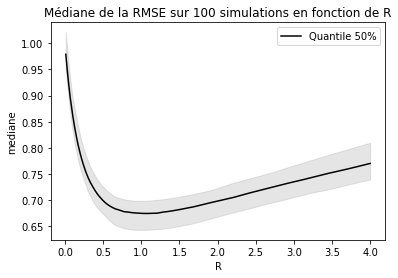

In [2]:
#Affichage de la médiane de la RMSE sur plusieurs simulations 
plt.plot(R_var,mediane,'k',label="Quantile 50%")
plt.title("Médiane de la RMSE sur 100 simulations en fonction de R") 
plt.xlabel("R")
plt.ylabel("mediane")
plt.fill_between(R_var,cinqp,quatp,color='grey',alpha=.2)
plt.legend()